# DeepSurv

https://nbviewer.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb

## Init

In [ ]:
# ! pip install sklearn-pandas

In [114]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [115]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

In [116]:
import sys

path_to_networks = os.path.join(ROOT, 'scripts')
sys.path.append(path_to_networks)

from networks import Net_3layers, Net_5layers

In [117]:
# available datasets:
#   clinical_miRNA_normalized_log.csv
#   clinical_miRNA_normalized_quant.csv
#   mRNA\\clinical_mRNA_normalized_log.csv
#   mRNA\\clinical_mRNA_normalized_tpm_log.csv
dataset = pd.read_csv(os.path.join(DATA_PATH, 'clinical_miRNA_normalized_log.csv'))

# set folder name for saving models: 
#   'miRNA_quant' for quantile normalized data
#   'miRNA_log' for log normalized data
#   'mRNA_log' for mRNA log normalized data
#   'mRNA_tpm_log' for mRNA TPM log normalized data
folder_name = 'miRNA_log'

In [118]:
print(dataset.shape)
print(dataset.columns)

columns_with_nan = dataset.columns[dataset.isna().sum() > 0]
print("Colonne con valori NaN:", columns_with_nan.tolist())

(746, 951)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB', 'pathologic_stage_Stage IIIA',
       'pathologic_stage_Stage IIIC',
       ...
       'hsa-mir-934', 'hsa-mir-935', 'hsa-mir-937', 'hsa-mir-938',
       'hsa-mir-939', 'hsa-mir-940', 'hsa-mir-942', 'hsa-mir-943',
       'hsa-mir-944', 'hsa-mir-95'],
      dtype='object', length=951)
Colonne con valori NaN: []


## Hyper-parameters

In [119]:
num_folds = 5
SEED = 42
WITH_CLINICAL = False  # If False, only miRNA/mRNA data will be used

In [120]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

## Data

In [121]:
dataset = dataset.rename(columns={'Death': 'event', 'days_to_last_followup': 'duration'})
dataset.drop(columns=['days_to_death'], inplace=True)

if not WITH_CLINICAL:
    # remove clinical data columns
    clinical_cols = [col for col in dataset.columns if not col.startswith('hsa') and col != 'duration' and col != 'event']
    dataset.drop(columns=clinical_cols, inplace=True)

In [122]:
y = dataset[['duration', 'event']].copy()

## Z-scaling

Note that PyTorch require variables of type 'float32'.

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

cols_leave = [col for col in dataset.columns if col.startswith('pathologic')]
cols_standardize = [col for col in dataset.columns if col not in cols_leave + ['duration', 'event']]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
X = dataset.drop(columns=['duration', 'event']) 
scaled_X = x_mapper.fit_transform(X).astype('float32')

## Data splitting

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=SEED)

In [175]:
print("y_train mean/std:", np.mean(y_train.values), np.std(y_train.values, axis=0))
print("y_test mean/std:", np.mean(y_test.values), np.std(y_test.values, axis=0))

y_train mean/std: 379.74580536912754 [9.53599875e+02 2.77226705e-01]
y_test mean/std: 467.0566666666667 [1.04137163e+03 3.24961536e-01]


## K-fold

In [126]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

## Neural net

non fare....

In [53]:
in_features = scaled_X.shape[1]

net = Net_3layers(in_features)

# a more complex net with more layers and different activations could be defined as follows
net_5 = Net_5layers(in_features)

## Training the model

We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by Smith 2017 (https://arxiv.org/pdf/1506.01186) to find a suitable learning rate with model.lr_finder. See this post for an explanation.

In [15]:
model = CoxPH(net, tt.optim.Adam)
#model = CoxPH(net_5, tt.optim.Adam)

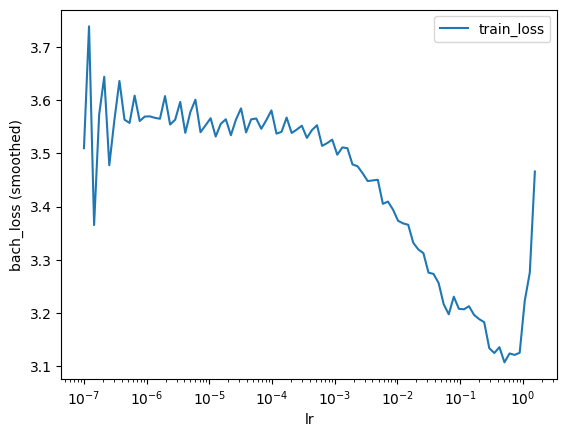

In [16]:
batch_size = 256

y_train = (y_train['duration'].to_numpy(dtype='float32'), y_train['event'].to_numpy(dtype='float32'))
lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [17]:
lrfinder.get_best_lr()

np.float64(0.050941380148164093)

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [18]:
model.optimizer.set_lr(0.01)

We include the EarlyStopping callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

#### Grid search + K-fold

In [155]:
import torch
from sklearn.model_selection import ParameterGrid
from torchtuples.callbacks import EarlyStopping

#y_train['duration'] = y_train['duration'].replace(0, 1)

y_train_tuple = (
    y_train['duration'].to_numpy(dtype='float32'),
    y_train['event'].to_numpy(dtype='float32')
)

def create_model(input_dim, params):
    net = Net_3layers(
        input_dim,
        hidden1=params['num_nodes_layer1'],
        hidden2=params['num_nodes_layer2'],
        dropout=params['dropout']
    )
    
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(params['lr'])
    return model

"""param_grid = {
    'num_nodes_layer1': [64, 128],
    'num_nodes_layer2': [32, 64],
    'dropout': [0.3, 0.5, 0.6],
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [64, 128, 256],
    'epochs': [200, 500],
}"""

param_grid = {
    'num_nodes_layer1': [64],
    'num_nodes_layer2': [32],
    'dropout': [0.6],
    'lr': [0.01],
    'batch_size': [256],
    'epochs': [512],
}

results = []

callbacks = [tt.callbacks.EarlyStopping(patience=25)]

for params in ParameterGrid(param_grid):
    scores = []
    logs = [] 
    vals = []
    
    for train_index, val_index in kf.split(X_train):
        # Select fold
        durations_train = y_train_tuple[0][train_index]
        events_train    = y_train_tuple[1][train_index]
        y_train_fold = (durations_train, events_train)
        
        durations_val = y_train_tuple[0][val_index]
        events_val    = y_train_tuple[1][val_index]
        y_val_fold = (durations_val, events_val)
    
        X_train_fold = X_train[train_index]
        X_val_fold   = X_train[val_index]
        
        val = X_val_fold, y_val_fold
        
        model = create_model(X_train_fold.shape[1], params)
    
        # Fit
        log = model.fit(
            X_train_fold,
            y_train_fold,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=callbacks,
            verbose=True,
            val_data=val,
            val_batch_size=params['batch_size'],
            shuffle=False,
            num_workers=1
        )
        
        logs.append(log.history if hasattr(log, 'history') else log)
        vals.append(val)
    
        # Evaluation
        if np.sum(events_val) != 0:
            _ = model.compute_baseline_hazards()
            surv = model.predict_surv_df(X_val_fold)
            ev = EvalSurv(surv, durations_val, events_val, censor_surv='km')
            scores.append(ev.concordance_td())
            

    results.append({
        'params': params,
        'mean_concordance': np.mean(scores) if scores else None,
        'concordances': scores,
        'logs': logs,
        'vals': vals,
    })

best_result = max(results, key=lambda x: x['mean_concordance'])
print("Migliori parametri:", best_result['params'])
print("Concordanza media:", best_result['mean_concordance'])
log = best_result['logs']
val = best_result['vals']


0:	[4s / 4s],		train_loss: 3.8951,	val_loss: 2.9807
1:	[3s / 8s],		train_loss: 3.6366,	val_loss: 2.9834
2:	[3s / 11s],		train_loss: 3.2749,	val_loss: 2.9226
3:	[3s / 15s],		train_loss: 3.5194,	val_loss: 2.8649
4:	[3s / 19s],		train_loss: 3.3206,	val_loss: 2.8448
5:	[3s / 22s],		train_loss: 3.4185,	val_loss: 2.8296
6:	[3s / 25s],		train_loss: 3.3205,	val_loss: 2.8033
7:	[3s / 29s],		train_loss: 3.3046,	val_loss: 2.8097
8:	[3s / 32s],		train_loss: 3.0815,	val_loss: 2.8199
9:	[3s / 36s],		train_loss: 3.1346,	val_loss: 2.8294
10:	[3s / 39s],		train_loss: 3.1651,	val_loss: 2.8409
11:	[4s / 43s],		train_loss: 2.7125,	val_loss: 2.8360
12:	[3s / 47s],		train_loss: 2.7853,	val_loss: 2.8134
13:	[3s / 51s],		train_loss: 3.0260,	val_loss: 2.8031
14:	[3s / 54s],		train_loss: 2.5690,	val_loss: 2.7965
15:	[3s / 58s],		train_loss: 2.5193,	val_loss: 2.7951
16:	[3s / 1m:1s],		train_loss: 2.8956,	val_loss: 2.7969
17:	[3s / 1m:5s],		train_loss: 2.5864,	val_loss: 2.8024
18:	[3s / 1m:9s],		train_loss: 2.448

Concordanza media: 0.5089947627738443
Concordanza media: 0.4762208694476934
Concordanza media: 0.45015331980866263
Concordanza media: 0.4983265085471019
Concordanza media: 0.5200750279320931
Concordanza media: 0.4785325780802877
Concordanza media: 0.5489216410321102

Provando con torch....

In [ ]:
import torch
from sklearn.model_selection import ParameterGrid
from torchtuples.callbacks import EarlyStopping

def create_model(input_dim, params):
    net = Net_3layers(
        input_dim,
        hidden1=params['num_nodes_layer1'],
        hidden2=params['num_nodes_layer2'],
        dropout=params['dropout']
    )
    
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(params['lr'])
    return model

"""param_grid = {
    'num_nodes_layer1': [64, 128],
    'num_nodes_layer2': [32, 64],
    'dropout': [0.3, 0.5, 0.6],
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [64, 128, 256],
    'epochs': [200, 500],
}"""
    
param_grid = {
    'num_nodes_layer1': [64],
    'num_nodes_layer2': [32],
    'dropout': [0.6],
    'lr': [0.01],
    'batch_size': [256],
    'epochs': [512],
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')        
X_train_torch = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tuple = (
    torch.tensor(y_train['duration'].to_numpy(dtype='float32'), dtype=torch.float32, device=device),
    torch.tensor(y_train['event'].to_numpy(dtype='float32'), dtype=torch.float32, device=device)
)
y_test_tuple = (
    torch.tensor(y_test['duration'].to_numpy(dtype='float32'), dtype=torch.float32, device=device),
    torch.tensor(y_test['event'].to_numpy(dtype='float32'), dtype=torch.float32, device=device)
)

def grid_search_kfold(X_train_torch, y_train_tuple, param_grid, kf):    
    results = []    
    callbacks = [tt.callbacks.EarlyStopping(patience=25)]    
        
    for params in ParameterGrid(param_grid):
        scores = []
        logs = [] 
        vals = []
        
        for train_index, val_index in kf.split(X_train_torch):   
            durations_train = y_train_tuple[0][train_index]
            events_train    = y_train_tuple[1][train_index]
            y_train_fold = (durations_train, events_train)
            
            durations_val = y_train_tuple[0][val_index]
            events_val    = y_train_tuple[1][val_index]
            y_val_fold = (durations_val, events_val)
        
            X_train_fold = X_train_torch[train_index]
            X_val_fold   = X_train_torch[val_index]
            
            val = (X_val_fold, y_val_fold)    
            
            model = create_model(X_train_fold.shape[1], params)
        
            # Fit
            log = model.fit(
                X_train_fold,
                y_train_fold,
                batch_size=params['batch_size'],
                epochs=params['epochs'],
                callbacks=callbacks,
                verbose=True,
                val_data=val,
                val_batch_size=params['batch_size'],
                shuffle=False,
            )
        
            logs.append(log.history if hasattr(log, 'history') else log)
            vals.append(val)
            
            # Evaluation
            if torch.sum(events_val).item() != 0:
                _ = model.compute_baseline_hazards()
                surv = model.predict_surv_df(X_val_fold)
                ev = EvalSurv(
                    surv,
                    durations_val.cpu().numpy(),
                    events_val.cpu().numpy(),
                    censor_surv='km'
                )
                scores.append(ev.concordance_td())
    
    
        results.append({
            'params': params,
            'mean_concordance': np.mean(scores),
            'logs': logs,
            'vals': vals,
        })
    
    best_result = max(results, key=lambda x: x['mean_concordance'])
    print("Migliori parametri:", best_result['params'])
    print("Concordanza media:", best_result['mean_concordance'])
    log = best_result['logs']
    val = best_result['vals']
    
    return best_result['mean_concordance']

In [ ]:
concordances = []
for i in range(1000):
    print(f"Grid search iteration {i+1}")
    concordances.append(grid_search_kfold(X_train_torch, y_train_tuple, param_grid, kf))

for i, concordance in enumerate(concordances):
    print(f"[{i}] Concordanza media: {concordance}")


Grid search iteration 1
0:	[0s / 0s],		train_loss: 3.7884,	val_loss: 2.9461
1:	[0s / 0s],		train_loss: 3.5540,	val_loss: 2.9066
2:	[0s / 0s],		train_loss: 3.3697,	val_loss: 2.9138
3:	[0s / 0s],		train_loss: 3.1589,	val_loss: 2.8901
4:	[0s / 0s],		train_loss: 3.4024,	val_loss: 2.7989
5:	[0s / 0s],		train_loss: 3.4235,	val_loss: 2.7430
6:	[0s / 0s],		train_loss: 3.9020,	val_loss: 2.7069
7:	[0s / 0s],		train_loss: 3.2885,	val_loss: 2.7163
8:	[0s / 0s],		train_loss: 3.9985,	val_loss: 2.7332
9:	[0s / 0s],		train_loss: 3.0851,	val_loss: 2.7461
10:	[0s / 0s],		train_loss: 3.2399,	val_loss: 2.7721
11:	[0s / 0s],		train_loss: 3.3087,	val_loss: 2.7964
12:	[0s / 0s],		train_loss: 3.0409,	val_loss: 2.8170
13:	[0s / 0s],		train_loss: 2.8265,	val_loss: 2.8350
14:	[0s / 0s],		train_loss: 3.4037,	val_loss: 2.8459
15:	[0s / 0s],		train_loss: 2.8234,	val_loss: 2.8542
16:	[0s / 0s],		train_loss: 2.8931,	val_loss: 2.8559
17:	[0s / 0s],		train_loss: 2.8966,	val_loss: 2.8537
18:	[0s / 0s],		train_loss: 2.75

Concordanza media: 0.5477097188450524
Concordanza media: 0.5137607998970395
Concordanza media: 0.547499293154357

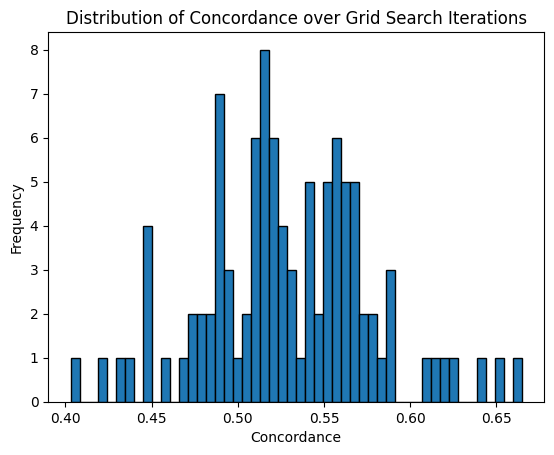

In [169]:
# plot concordance distribution
plt.hist(concordances, bins=50, edgecolor='black')
plt.xlabel('Concordance')
plt.ylabel('Frequency')
plt.title('Distribution of Concordance over Grid Search Iterations')
plt.show()

In [167]:
# confidence interval
import scipy.stats as stats

mean_concordance = np.mean(concordances)
std_concordance = np.std(concordances, ddof=1)
confidence_level = 0.95
degrees_freedom = len(concordances) - 1

confidence_interval = stats.t.interval(
    confidence_level,
    degrees_freedom,
    loc=mean_concordance,
    scale=std_concordance / np.sqrt(len(concordances))
)
print(f"Mean concordance: {mean_concordance}")
print(f"95% confidence interval: {confidence_interval}")


Mean concordance: 0.5290199958358308
95% confidence interval: (np.float64(0.5192945276589181), np.float64(0.5387454640127435))


In [153]:
_ = best_result['logs'][0].plot()  # TODO set correct index

AttributeError: 'list' object has no attribute 'plot'

In [152]:
model.partial_log_likelihood(*best_result['vals'][0]).mean()  # TODO set correct index

np.float32(-2.9915988)

## Prediction

However, as CoxPH is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

In [29]:
_ = model.compute_baseline_hazards()

#surv = model.predict_surv_df(x_test)
surv = model.predict_surv_df(X_test)

In [154]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

KeyError: 'survs'

## Evaluation

We can use the EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [31]:
#ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev = EvalSurv(surv, y_test['durations'], y_test['events_test'], censor_surv='km')

In [32]:
ev.concordance_td()

0.489281210592686

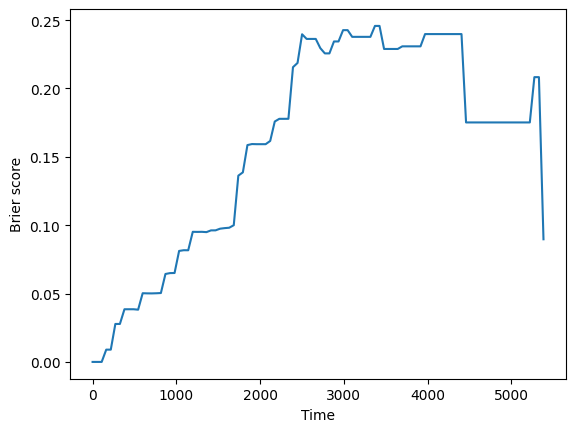

In [33]:
#time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid = np.linspace(y_test['durations'].min(), y_test['events_test'].max(), 100)
_ = ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

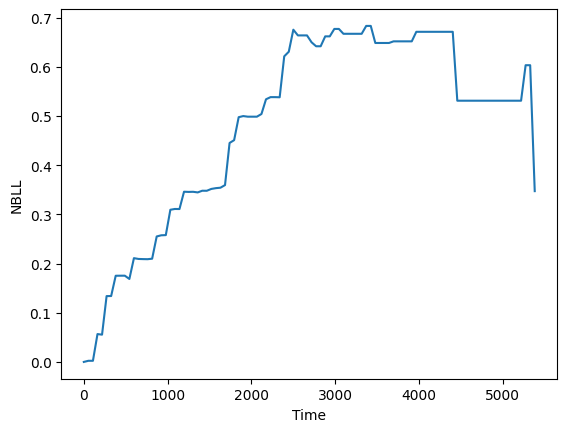

In [34]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score Graf et al. 1999. In practice this is done by numerical integration over a defined time_grid.

In [35]:
ev.integrated_brier_score(time_grid)

np.float64(0.16017628476075108)

In [36]:
ev.integrated_nbll(time_grid)

np.float64(0.4838034351753425)